# Knowledge Graph construction and query with extracted software metadata

This notebook first generates a knowledge graph from the information extracted about software repositories. It is later queried to assess the good practices followed by the extracted repositories.

In [1]:
import morph_kgc
import pyoxigraph
import re

## KG Construction
The knowledge graph is generated using Morph-KGC, that uses RML mappings to transform the JSON file into RDF. This tool requires some configuration parameters, where we indicate the desired output serialisation and the name and path to the RML mapping file. Then, the kg is generated and stored as a oxigraph store in the variable `graph`, that it is also saved as a `.nq` file.

In [2]:
config = """
             [CONFIGURATION]
             output_format=N-QUADS
             
             [SOMEF-json]
             mappings=../mappings/mapping-somef-star.ttl
         """

In [3]:
graph = morph_kgc.materialize_oxigraph(config)

INFO | 2023-07-04 09:43:53,297 | 145 mapping rules retrieved.
INFO | 2023-07-04 09:43:53,305 | Mappings processed in 1.267 seconds.
INFO | 2023-07-04 09:44:03,132 | Number of triples generated in total: 19394.


In [4]:
graph.add(pyoxigraph.Quad(
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/20230628'),
    pyoxigraph.NamedNode('http://purl.org/dc/terms/created'),
    pyoxigraph.Literal('2023-06-28 00:00:00', datatype=pyoxigraph.NamedNode('http://www.w3.org/2001/XMLSchema#dateTime')),
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/default')))
graph.add(pyoxigraph.Quad(
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/20230628'),
    pyoxigraph.NamedNode('http://www.w3.org/ns/prov#wasAttributedTo'),
    pyoxigraph.Literal('SOftware Metadata Extraction Framework (SOMEF)', datatype=pyoxigraph.NamedNode('http://www.w3.org/2001/XMLSchema#string')),
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/default')))

In [156]:
with open('/Users/aiglesias/GitHub/oeg-software-graph/data/somef-kg.nq', 'w') as result:
    result.write(str(graph))

## KG querying - FAIRness assessment

Counting all repositories

In [12]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?s) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?s a sd:Software
            }
""")

for solution in q_res:
    print("Total number of repositories:", solution['count_software'].value)
    result_list['total_repos'] = solution['count_software'].value

Total number of repositories: 270


### BP 1: Description is available

In [124]:
# query debug
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT DISTINCT ?software ?desc
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:description ?desc 
            }
""")

for solution in q_res:
    print(solution['software'], solution['desc'])


<https://www.w3id.org/okn/i/Software/oeg-upm/delta-ontology> "DELTA ontology "
<https://www.w3id.org/okn/i/Software/oeg-upm/rmlc-statistic> "RMLC iterator"
<https://www.w3id.org/okn/i/Software/oeg-upm/S4WATR> "Water Ontology"
<https://www.w3id.org/okn/i/Software/oeg-upm/morph-streams-web> "morph-web"
<https://www.w3id.org/okn/i/Software/oeg-upm/awesome-semantic-web> "A curated list of various semantic web and linked data resources. \nTo add something to the list please either submit a pull request or add a comment with a link to [issues/awesomelets](https://github.com/semantalytics/awesome-semantic-web/issues/81). Pull requests will be evaluated immediately for inclusion while posts while awesomelets will be evaluated at some indeterminate time in the future.  \n"
<https://www.w3id.org/okn/i/Software/oeg-upm/LDP4RO> "Project to create Research Objects following the LDP model and using LDP4J"
<https://www.w3id.org/okn/i/Software/oeg-upm/easytv-semantic-annotator> "This repo contains all

Counting number of repositories with description (long and short)

In [13]:
bp1_1 = """
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?software_count) 
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:description ?desc 
            }
"""
q_res = graph.query(bp1_1)
result_list = {}

for solution in q_res:
    print("Total number of descriptions:", solution['software_count'].value)
    result_list['total_description'] = solution['software_count'].value

Total number of descriptions: 395


Numer of software with descriptions by type: long (README) or short (GitHub API)

In [14]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software_short) AS ?short_desc_count)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software_short sd:description ?desc_short >> sd:technique "GitHub_API".
            }
""")

for solution in q_res:
    print("Total number of repositories with short description:", solution['short_desc_count'].value)
    result_list['total_short_desc'] = solution['short_desc_count'].value
    

Total number of repositories with short description: 200


In [15]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            
            SELECT (COUNT (DISTINCT ?software_long) AS ?long_desc_count)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software_long sd:description ?desc_long >> sd:technique ?long_technique ;
                                                            sd:confidence ?long_conf .
                VALUES ?long_technique {"supervised_classification" "header_analysis"}
                FILTER(xsd:float(?long_conf) > 0.98)
            }
""")

for solution in q_res:
    print("Total number of repositories with long description:", solution['long_desc_count'].value)
    result_list['total_long_desc'] = solution['long_desc_count'].value
    

Total number of repositories with long description: 88


### BP2: Persistent identifier
Repositories that provide a DOI (not from a publication, but from e.g. Zenodo)

In [16]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:identifier ?id 
            }
""")

for solution in q_res:
    print("Total number of repositories with DOI:", solution['count_software'].value)
    result_list['total_id'] = solution['count_software'].value


Total number of repositories with DOI: 21


### BP3: Download URL
Repositories that provide a URL for download from releases

In [17]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasVersion ?version 
            }
""")

for solution in q_res:
    print("Total number of repositories with download URL:", solution['count_software'].value)
    result_list['total_down_url'] = solution['count_software'].value


Total number of repositories with download URL: 81


### BP4: A software versioning scheme is followed
If tags follows semantic versioning scheme

In [19]:
def is_semantic_version(version):
    pattern = r"^[v|V]?(0|[1-9]\d*)\.(0|[1-9]\d*)\.(0|[1-9]\d*)(?:-([0-9A-Za-z-]+(?:\.[0-9A-Za-z-]+)*))?(?:\+([0-9A-Za-z-]+(?:\.[0-9A-Za-z-]+)*))?$"
    return re.match(pattern, version) is not None

In [21]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT DISTINCT ?software (GROUP_CONCAT (?versionId) AS ?ids)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasVersion/sd:hasVersionId ?versionId
            } GROUP BY ?software
""")


total_semantic_versioning = 0
for solution in q_res:
    version_ids = solution['ids'].value
    version_ids_array = version_ids.split(' ')
    results = [True if is_semantic_version(version) else False for version in version_ids_array]
    overall_res = False if False in results else True
    total_semantic_versioning = total_semantic_versioning if False in results else total_semantic_versioning + 1

print("Total number of repositories with semantic versioning:", total_semantic_versioning)
result_list['total_semantic_versioning'] = total_semantic_versioning


Total number of repositories with semantic versioning: 30


### BP5: Documentation is available

In [22]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasDocumentation ?doc 
            }
""")

for solution in q_res:
    print("Total number of repositories with available documentation:", solution['count_software'].value)
    result_list['total_docs'] = solution['count_software'].value


Total number of repositories with available documentation: 42


### BP6: License available

In [23]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software a sd:Software ;
                          schema:license ?license .
                ?license a schema:CreativeWork ;
                         sd:name ?license_name .
            }
""")

for solution in q_res:
    print("Total number of repositories with license:", solution['count_software'].value)
    result_list['total_license'] = solution['count_software'].value


Total number of repositories with license: 164


### BP7: Explicit citation

In [25]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software sd:citation ?cite >> prov:hadPrimarySource ?source
                FILTER(CONTAINS(str(?source),'README'))
            }
""")

for solution in q_res:
    print("Total number of repositories with citation in README:", solution['count_software'].value)
    result_list['readme_citation'] = solution['count_software'].value


Total number of repositories with citation in README: 20


In [26]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software sd:citation ?cite >> prov:hadPrimarySource ?source
                FILTER(CONTAINS(str(?source),'.cff'))
            }
""")

for solution in q_res:
    print("Total number of repositories with CFF citation file:", solution['count_software'].value)
    result_list['cff_citation'] = solution['count_software'].value


Total number of repositories with CFF citation file: 5


### BP8: Available software metadata
Programming language, date created, at least one release and keywords

In [27]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasSourceCode/sd:programmingLanguage ?language .
                ?software sd:dateCreated ?date .
                ?software sd:description ?desc .
                ?software sd:hasVersion ?rel .
                ?software sd:keywords ?keys .
                
            }
""")

for solution in q_res:
    print("Total number of repositories with minimum metadata:", solution['count_software'].value)
    result_list['total_repo_metadata'] = solution['count_software'].value


Total number of repositories with minimum metadata: 22


### BP9: Installation instructions

In [28]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasInstallationInstructions ?inst .
                
            }
""")

for solution in q_res:
    print("Total number of repositories with installation instructions:", solution['count_software'].value)
    result_list['total_install_inst'] = solution['count_software'].value


Total number of repositories with installation instructions: 60


### BP10: Software requirements

In [29]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:softwareRequirements ?requirements .
                
            }
""")

for solution in q_res:
    print("Total number of repositories with software requirements:", solution['count_software'].value)
    result_list['total_soft_requirements'] = solution['count_software'].value


Total number of repositories with software requirements: 22


## Graphics and statistics

In [42]:
import matplotlib.pyplot as plt

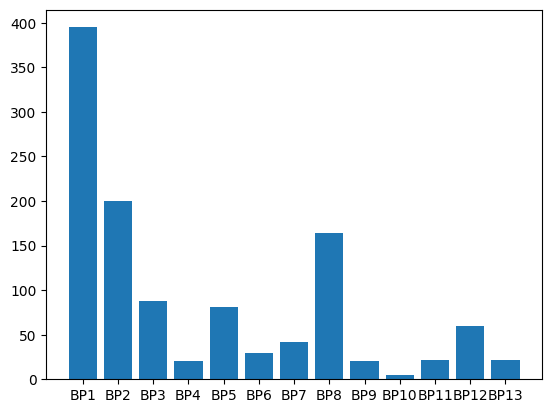

In [45]:
numeric_result_list = dict([a, int(x)] for a, x in result_list.items()) 

plt.bar(*zip(*numeric_result_list.items()))
plt.xticks(range(len(numeric_result_list)), list(['BP1','BP2','BP3','BP4','BP5','BP6','BP7','BP8','BP9','BP10','BP11','BP12','BP13',]))

plt.show()